In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyqubo import Array, Binary , Placeholder,Constraint, solve_qubo
from itertools import combinations
from sklearn.metrics import accuracy_score
import math
import pandas as pd
from sklearn.model_selection import train_test_split
import neal
from dwave.system import DWaveSampler, FixedEmbeddingComposite, EmbeddingComposite

class OneVsRestClassifier:
    def __init__(self, class_num, classifier, params=None):
        """binary classifierを受け取り、クラスの数分インスタンスを作成する."""
        self.class_num = class_num
        if params is None:
            self.classifiers = [classifier() for _ in range(class_num)]
        else:
            self.classifiers = [classifier(**params) for _ in range(class_num)]

    def solve(self, x, y):
        for i in range(self.class_num):
            print(f"Training classifier {i}...")
            self.classifiers[i].solve(x, self.re_labaling(y, i))
        return self

    def re_labaling(self, y, pos_label):
        """labelを受け取り、pos_labelに指定したカテゴリを+1、それ以外を-1にラベリングしなおしたデータを返す."""
        return np.where(y == pos_label, 1, -1)

    def argmax_by_E(self, result):

        for i in range(result.shape[0]):
            for j in range(result.shape[1]):
                if np.sum(result[:, j], axis=0) == -1: #case (1,-1,-1)
                    pass
                elif np.sum(result[:, j], axis=0) == 1: #case (1,1,-1)
                    a = np.array(np.where(result[:, j] == 1))[0][0]
                    b = np.array(np.where(result[:, j] == 1))[0][1]
                    if self.classifiers[a].energy > self.classifiers[b].energy:
                        result[a, j] = -1
                    else:
                        result[b, j] = -1
                elif np.sum(result[:, j], axis=0) == 3: #case (1,1,1)
                    min_e = np.argmin(np.array([self.classifiers[0].energy, self.classifiers[1].energy, self.classifiers[2].energy]))
                    result[0:min_e, j] = -1
                    result[min_e:i, j] = -1
                elif np.sum(result[:, j], axis=0) == -3: #case (-1,-1,-1)
                    min_e = np.argmin(
                        np.array([self.classifiers[0].energy, self.classifiers[1].energy, self.classifiers[2].energy]))
                    result[min_e, j] = 1

        print("result", result)
        return np.argmax(result, axis=0)

    def predict(self, X):

        result = np.array([model.predict(X) for model in self.classifiers])
        #print("result", result)
        #print("result type and shape", type(result), result.shape)
        #result type and shape <class 'numpy.ndarray'> (3, 150)
        return self.argmax_by_E(result)

    def evaluate(self, X, y):
        pred = self.predict(X)
        print("pred result",pred)
        return accuracy_score(y, pred)
    
class qSVM():
    def __init__(self, data, label, B=2, K=2, Xi=1, gamma = 10, C=3, kernel="rbf", optimizer="PQA"):
        """
        :param B:
        :param K:
        :param Xi:
        :param gamma:
        :param C: #still not used now
        :param kernel: default;rbf only rbf for now,
        :param optimizer:SA,QA, PQA
        """
        #self.data = data
        self.label = label
        self.B = B
        self.K = K
        self.N = data.shape[0]
        self.Xi = Xi
        self.gamma = float(gamma)
        self.C = C
        self.kernel = kernel

        self.options = {
            'SA': {},
            'PQA': {}
        }
        self.optimizer = optimizer
        self.alpha = Array.create('alpha', shape=self.K * self.N, vartype='BINARY') #number of spins : K*N

        self.alpha_result = None
        self.alpha_result_array = None
        self.alpha_real = np.zeros((self.N,))

        self._support_vectors = None
        self._n_support = None
        self._alphas = None
        self._support_labels = None
        self._indices = None
        self.intercept = None
        self.energy = None

    def rbf(self, x, y):
        return np.exp(-1.0 * self.gamma * np.dot(np.subtract(x, y).T, np.subtract(x, y)))

    def transform(self, X):
        K = np.zeros([X.shape[0], X.shape[0]])
        for i in range(X.shape[0]):
            for j in range(X.shape[0]):
                K[i, j] = self.rbf(X[i], X[j])
        return K

    def makeQUBO(self, data, label):

        alpha = self.alpha
        x = data
        t = label
        
        energy = 0
        for n in range(self.N):
            for m in range(self.N):
                for k in range(self.K):
                    for j in range(self.K):
                        alpha[self.K * n +k] * alpha[self.K * m +j] * t[n] * t[m] * self.rbf(x[n],x[m]) * self.B ** (k+j)

        const_1=0
        for n in range(self.N):
            for k in range(self.K):
                const_1 += alpha[self.K * n +k] * self.B ** k

        const_2=0
        for n in range(self.N):
            for k in range(self.K):
                const_2 += alpha[self.K * n +k] * t[n] * self.B ** k

        const_2= const_2 ** 2

        h = 0.5 * energy - const_1 + self.Xi * const_2

        model = h.compile()
        qubo, offset = model.to_qubo()

        return model,qubo

    def PyquboToNparray(self, qubo_dict):
        # qubo generate by pyqubo is tuple type data, this func for changing the qubo from dict to np.array
        # qubometasolver need a (spins_num,spins_num) size np.array type value
        # pyqubo generate a dict type qubo and only has the triangle of qubo like this
        # 2.9, 1.4, 2.6
        # null, 1.7, 5.2
        # null, null, 3.7
        # so dict length is spins*spins/2

        #print("Pyqubo before sort",qubo_dict)

        qubo = np.zeros((self.K * self.N, self.K * self.N))
        for i in range (self.K * self.N):
            for j in range (i, self.K * self.N):
                qubo[i][j] = qubo_dict.get(('alpha[%s]' % i, 'alpha[%s]' % j))
                if math.isnan(qubo[i][j]):
                    qubo[i][j] = qubo_dict.get(('alpha[%s]' % j, 'alpha[%s]' % i))

        return qubo

    def solve(self, data, label):
        print("solving...")
        model, qubo = self.makeQUBO(data, label) #type(qubo) = dict
        print(len(qubo.values()))
        # print("Active optimizer: ", self.optimizer)
        # npqubo = self.PyquboToNparray(qubo)
        # print(np.shape(npqubo))

        if self.optimizer == "SA":
            #optimizer = self.optimizer(**self.options['neal'])
            sampleset = neal.SimulatedAnnealingSampler().sample_qubo(qubo)
            
            self.energy = sampleset.record['energy']
            self.alpha_result = sampleset.record['sample']
            self.alpha_result = np.reshape(self.alpha_result,(self.K * self.N))

            # # # ------- Set up D-Wave parameters -------
            # token = 'DEV-e6f6f6bb339c85b8cd1357653152e575cd618efb' #saihnaa_0810
            # endpoint = 'https://cloud.dwavesys.com/sapi/'
            # dw_sampler = DWaveSampler(solver='Advantage_system6.4', token=token, endpoint=endpoint)

            # sampler = EmbeddingComposite(dw_sampler)
            # response = sampler.sample_qubo(qubo, num_reads=100, annealing_time = 20, label='SVM').first

            # self.energy = response[1]
            # self.alpha_result = list(response[0].values())
            # self.alpha_result = np.reshape(self.alpha_result,(self.K * self.N))
            
        else:
            print("This optimizer is not available")

        # print("alpha_result = ", self.alpha_result)
        # print("energy = {}".format(self.energy))

        K = self.transform(data)

        print("K,N",self.K, self.N)
        for i in range(self.N):
            for j in range(self.K):
                self.alpha_real[i] += self.alpha_result[self.K*i+j] * self.B ** j

        is_sv = self.alpha_real > 1e-5
        # print("(self.alpha_real)", self.alpha_real)
        self._support_vectors = data[is_sv]
        self._n_support = np.sum(is_sv)
        self._alphas = self.alpha_real[is_sv]
        self._support_labels = label[is_sv]
        self._indices = np.arange(data.shape[0])[is_sv]  # the index of supported vector
        self.intercept = 0

        for i in range(self._alphas.shape[0]):
            self.intercept += self._support_labels[i]
            self.intercept -= np.sum(self._alphas * self._support_labels * K[self._indices[i], is_sv])
        self.intercept /= self._alphas.shape[0]
        print("self.intercept", self.intercept)

        return self.alpha_result

    def signum(self, X):
        return np.where(X > 0, 1, -1)

    def predict(self, X):
        score = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            s = 0
            for alpha, label, sv in zip(self.alpha_result, self._support_labels, self._support_vectors):
                s += alpha * label * self.rbf(X[i], sv) * self.B ** self.K
            score[i] = s
        score = score + self.intercept
        return self.signum(score)

    def evaluate(self, X, y):
        pred = self.predict(X)
        return accuracy_score(y, pred)
    
def qubo_dict_to_np(qubo_dict):
    n = int(np.sqrt(len(qubo_dict)))
    qubo_np = np.zeros((n, n))
    for ((i, j), value) in qubo_dict.items():
        qubo_np[int(i.split('[')[1].split(']')[0])][int(j.split('[')[1].split(']')[0])] = value
    return qubo_np

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Load dataset
n_samples = 100
X, y = datasets.make_moons(n_samples=n_samples, noise=0.01, random_state=420)
data = X
alpha = y
N = n_samples

# Preprocess dataset
y = LabelEncoder().fit_transform(y)

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=240)

gamma = 10
# Set the parameters for the qSVM
params = {
    "data": X_train,
    "label": y_train,
    "B": 2,
    "K": 2,
    "Xi": 1,
    "gamma": gamma,
    "C": 1,
    "kernel": "rbf",
    "optimizer": "SA"
}

# Train OneVsRestClassifier
one_vs_rest = OneVsRestClassifier(class_num=2, classifier=qSVM, params=params) # make_moons has two classes

# qubo_dict = qSVM.makeQUBO(X_train, y_train, 0.1)
# qubo_np = qubo_dict_to_np(qubo_dict)

# print(qubo_np)

# Re-train the OneVsRestClassifier on the projected data
one_vs_rest.solve(X_train, y_train)

# Evaluate OneVsRestClassifier
accuracy = one_vs_rest.evaluate(X_test, y_test)

# Create a mesh to plot in
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

# Define colors and markers for each class
colors = ['red', 'blue']
markers = ['s', 'o', "v", "^"]

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
Z = one_vs_rest.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.8, cmap=ListedColormap(colors))

# Plot training samples
for idx, cl in enumerate(np.unique(y_train)):
    plt.scatter(x=X_train[y_train == cl, 0], 
                y=X_train[y_train == cl, 1],
                alpha=0.8, 
                color=colors[idx],
                marker=markers[idx], 
                label=f'Training class {cl}', 
                edgecolor='black')

# Plot test samples
for idx, cl in enumerate(np.unique(y_test)):
    plt.scatter(x=X_test[y_test == cl, 0], 
                y=X_test[y_test == cl, 1],
                alpha=0.8, 
                color=colors[idx],
                marker=markers[idx+2], 
                label=f'Test class {cl}', 
                edgecolor='black')

# Add a title with the accuracy
plt.title(f'qSVM Decision Boundary, Test Accuracy: {accuracy*100:.2f}%')

# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
plt.legend(loc='best')

path = "results/moon_test_" + str(n_samples) + "_" + str(gamma)
# plt.savefig(path,  bbox_inches='tight', dpi = 100)

plt.show()

ImportError: dynamic module does not define module export function (PyInit_testing)

In [49]:
import numpy as np
from pyqubo import Array, Binary, Placeholder, Constraint, solve_qubo
from itertools import combinations
from sklearn.metrics import accuracy_score
import math
import neal
from dwave.system import DWaveSampler, FixedEmbeddingComposite, EmbeddingComposite
from collections import Counter

class OneVsOneClassifier:
    def __init__(self, class_num, classifier, params=None):
        self.class_num = class_num
        self.classifiers = {}
        self.params = params
        # Initialize one classifier for each pair of classes
        for i in range(class_num):
            for j in range(i + 1, class_num):
                if params is None:
                    self.classifiers[(i, j)] = classifier()
                else:
                    self.classifiers[(i, j)] = classifier(**params)
    
    def solve(self, X, y):
        # Train each classifier on the data from the two classes it's responsible for
        for (i, j), clf in self.classifiers.items():
            idx = np.where((y == i) | (y == j))
            X_train = X[idx]
            y_train = y[idx]
            # Relabel class i to 1 and class j to -1
            y_train = np.where(y_train == i, 1, -1)
            print(f"Training classifier for classes {i} vs {j}...")
            clf.solve(X_train, y_train)
        return self

    def predict(self, X):
        results = []
        # Collect votes from each classifier
        for (i, j), clf in self.classifiers.items():
            pred = clf.predict(X)
            # Convert binary predictions back to the original class labels
            pred = np.where(pred == 1, i, j)
            results.append(pred)
        
        # The final prediction for each sample is the class that gets the most votes
        results = np.array(results).T
        final_pred = np.array([Counter(row).most_common(1)[0][0] for row in results])
        return final_pred

    def evaluate(self, X, y):
        pred = self.predict(X)
        accuracy = np.mean(pred == y)
        print(f"Prediction accuracy: {accuracy*100:.2f}%")
        return accuracy

class OneVsRestClassifier:
    def __init__(self, class_num, classifier, params=None):
        """binary classifierを受け取り、クラスの数分インスタンスを作成する."""
        self.class_num = class_num
        if params is None:
            self.classifiers = [classifier() for _ in range(class_num)]
        else:
            self.classifiers = [classifier(**params) for _ in range(class_num)]

    def solve(self, x, y):
        for i in range(self.class_num):
            print(f"Training classifier {i}...")
            self.classifiers[i].solve(x, self.re_labaling(y, i))
        return self

    def re_labaling(self, y, pos_label):
        """labelを受け取り、pos_labelに指定したカテゴリを+1、それ以外を-1にラベリングしなおしたデータを返す."""
        return np.where(y == pos_label, 1, -1)

    def argmax_by_E(self, result):
        for i in range(result.shape[0]):
            for j in range(result.shape[1]):
                if np.sum(result[:, j], axis=0) == -1: #case (1,-1,-1)
                    pass
                elif np.sum(result[:, j], axis=0) == 1: #case (1,1,-1)
                    a = np.array(np.where(result[:, j] == 1))[0][0]
                    b = np.array(np.where(result[:, j] == 1))[0][1]
                    if self.classifiers[a].energy > self.classifiers[b].energy:
                        result[a, j] = -1
                    else:
                        result[b, j] = -1
                elif np.sum(result[:, j], axis=0) == 3: #case (1,1,1)
                    min_e = np.argmin(np.array([self.classifiers[0].energy, self.classifiers[1].energy, self.classifiers[2].energy]))
                    result[0:min_e, j] = -1
                    result[min_e:i, j] = -1
                elif np.sum(result[:, j], axis=0) == -3: #case (-1,-1,-1)
                    min_e = np.argmin(
                        np.array([self.classifiers[0].energy, self.classifiers[1].energy, self.classifiers[2].energy]))
                    result[min_e, j] = 1

        print("result", result)
        return np.argmax(result, axis=0)

    def predict(self, X):
        result = np.array([model.predict(X) for model in self.classifiers])
        print("result123", result)
        #print("result type and shape", type(result), result.shape)
        #result type and shape <class 'numpy.ndarray'> (3, 150)
        return self.argmax_by_E(result)

    def evaluate(self, X, y):
        pred = self.predict(X)
        print("pred result",pred)
        return accuracy_score(y, pred)
    
class qSVM():
    def __init__(self, data, label, B=2, K=2, Xi=1, gamma = 10, C=3, kernel="rbf", optimizer="SA"):
        """
        :param B:
        :param K:
        :param Xi:
        :param gamma:
        :param C: #still not used now
        :param kernel: default;rbf only rbf for now,
        :param optimizer:SA,QA, PQA
        """
        # self.data = data
        self.label = label
        self.B = B
        self.K = K
        self.N = data.shape[0]
        self.Xi = Xi
        self.gamma = float(gamma)
        self.C = C
        self.kernel = kernel

        self.options = {
            'SA': {},
            'PQA': {}
        }
        self.optimizer = optimizer
        self.alpha = Array.create('alpha', shape=self.K * self.N, vartype='BINARY') #number of spins : K*N

        self.alpha_result = None
        self.alpha_result_array = None
        self.alpha_real = np.zeros((self.N,))

        self._support_vectors = None
        self._n_support = None
        self._alphas = None
        self._support_labels = None
        self._indices = None
        self.intercept = None
        self.energy = None


    def rbf(self, x, y):
        return np.exp(-1.0 * self.gamma * np.dot(np.subtract(x, y).T, np.subtract(x, y)))

    def transform(self, X):
        K = np.zeros([X.shape[0], X.shape[0]])
        for i in range(X.shape[0]):
            for j in range(X.shape[0]):
                K[i, j] = self.rbf(X[i], X[j])
        return K

    def makeQUBO(self, data, label):
        alpha = self.alpha
        x = data
        t = label
        
        energy = 0
        for n in range(self.N):
            for m in range(self.N):
                for k in range(self.K):
                    for j in range(self.K):
                        alpha[self.K * n +k] * alpha[self.K * m +j] * t[n] * t[m] * self.rbf(x[n],x[m]) * self.B ** (k+j)

        const_1=0
        for n in range(self.N):
            for k in range(self.K):
                const_1 += alpha[self.K * n +k] * self.B ** k

        const_2=0
        for n in range(self.N):
            for k in range(self.K):
                const_2 += alpha[self.K * n +k] * t[n] * self.B ** k

        const_2= const_2 ** 2

        h = 0.5 * energy - const_1 + self.Xi * const_2

        model = h.compile()
        qubo, offset = model.to_qubo()

        return model,qubo

    def PyquboToNparray(self, qubo_dict):
        # qubo generate by pyqubo is tuple type data, this func for changing the qubo from dict to np.array
        # qubometasolver need a (spins_num,spins_num) size np.array type value
        # pyqubo generate a dict type qubo and only has the triangle of qubo like this
        # 2.9, 1.4, 2.6
        # null, 1.7, 5.2
        # null, null, 3.7
        # so dict length is spins*spins/2

        #print("Pyqubo before sort",qubo_dict)

        qubo = np.zeros((self.K * self.N, self.K * self.N))
        for i in range (self.K * self.N):
            for j in range (i, self.K * self.N):
                qubo[i][j] = qubo_dict.get(('alpha[%s]' % i, 'alpha[%s]' % j))
                if math.isnan(qubo[i][j]):
                    qubo[i][j] = qubo_dict.get(('alpha[%s]' % j, 'alpha[%s]' % i))

        return qubo

    def solve(self, data, label):
        print("solving...")
        model, qubo = self.makeQUBO(data, label) #type(qubo) = dict
        # print(len(qubo.values()))
        # print("Active optimizer: ", self.optimizer)
        # npqubo = self.PyquboToNparray(qubo)
        # print(np.shape(npqubo))

        if self.optimizer == "SA":
            sampleset = neal.SimulatedAnnealingSampler().sample_qubo(qubo)
            
            self.energy = sampleset.record['energy']
            self.alpha_result = sampleset.record['sample']
            self.alpha_result = np.reshape(self.alpha_result,(self.K * self.N))
            
        else:
            print("This optimizer is not available")

        K = self.transform(data)

        print("K,N",self.K, self.N)
        for i in range(self.N):
            for j in range(self.K):
                self.alpha_real[i] += self.alpha_result[self.K*i+j] * self.B ** j

        is_sv = self.alpha_real > 1e-5
        # print("(self.alpha_real)", self.alpha_real)
        self._support_vectors = data[is_sv]
        self._n_support = np.sum(is_sv)
        self._alphas = self.alpha_real[is_sv]
        self._support_labels = label[is_sv]
        self._indices = np.arange(data.shape[0])[is_sv]  # the index of supported vector
        self.intercept = 0

        for i in range(self._alphas.shape[0]):
            self.intercept += self._support_labels[i]
            self.intercept -= np.sum(self._alphas * self._support_labels * K[self._indices[i], is_sv])
        self.intercept /= self._alphas.shape[0]
        print("self.intercept", self.intercept)

        return self.alpha_result

    def signum(self, X):
        return np.where(X > 0, 1, -1)

    def predict(self, X):
        score = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            s = 0
            for alpha, label, sv in zip(self.alpha_result, self._support_labels, self._support_vectors):
                s += alpha * label * self.rbf(X[i], sv) * self.B ** self.K
            score[i] = s
        score = score + self.intercept
        # return self.signum(score)
        return score

    def evaluate(self, X, y):
        pred = self.predict(X)
        return accuracy_score(y, pred)
    
def qubo_dict_to_np(qubo_dict):
    n = int(np.sqrt(len(qubo_dict)))
    qubo_np = np.zeros((n, n))
    for ((i, j), value) in qubo_dict.items():
        qubo_np[int(i.split('[')[1].split(']')[0])][int(j.split('[')[1].split(']')[0])] = value
    return qubo_np

Training classifier 0...
solving...
K,N 2 120
self.intercept 34.65357697318329
Training classifier 1...
solving...
K,N 2 120
self.intercept 28.980916833926244
Training classifier 2...
solving...
K,N 2 120
self.intercept 25.75731950725548
result123 [[ 139.32548079  136.91283936  130.16061532  -89.44337647 -109.04739534
  -119.28122453 -105.44103846  -70.84452803 -119.05566079  139.32548079
  -116.46423859  138.32234531  137.29156084  -32.11821345 -119.28122453
   -89.83312348  -77.78492899  -84.14133692  138.55462416  -92.36082187
   -49.15857631  139.02310591  -90.25150948  -98.29730446  -89.83312348
   -38.95123921   -4.56600627  -96.71233468  137.63701843  138.24814522]
 [ -44.07291884  -42.36772748  -37.92623735  -13.28398678   41.63331088
    18.01871163   47.6481374    63.08859834    9.22874643  -44.07291884
    -4.14157632  -43.42505619  -42.79187989  -12.26505958   18.01871163
    58.70687135   62.31762555   60.85129216  -43.44838771   -0.66818393
    63.01156724  -43.94337762  

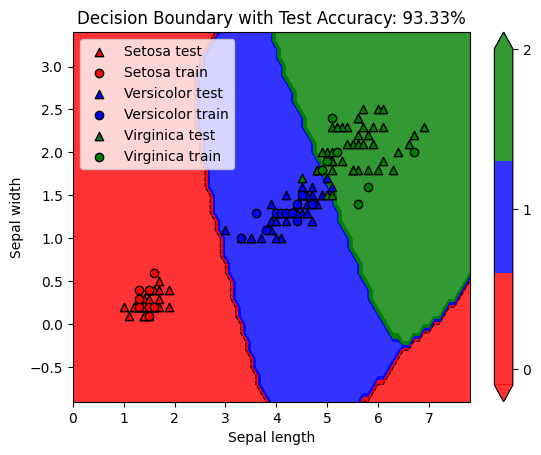

In [39]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.datasets import load_digits
# from sklearn.datasets import load_svmlight_file

iris_dataset = load_iris()

iris_x = iris_dataset.data[:,2:]
iris_y = iris_dataset['target']

# Load data and preprocess
# n_samples = 3*20
# X, y = datasets.make_blobs(n_samples=n_samples, centers=3, random_state=42)
X, y = iris_x, iris_y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# Define SVM parameters
gamma = 0.5
params = {
    "data": X_train,
    "label": y_train,
    "B": 2,
    "K": 2,
    "Xi": 1,
    "gamma": gamma,
    "C": 3,
    "kernel": "rbf",
    "optimizer": "SA"
}

# Initialize and train the classifier
one_vs_rest = OneVsRestClassifier(class_num=3, classifier=qSVM, params=params)
one_vs_rest.solve(X_train, y_train)

# Evaluate the classifier
accuracy = one_vs_rest.evaluate(X_test, y_test)

# Create a mesh to plot the decision boundary
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
print(xx.shape)

# Predict class for each point in the mesh
Z = one_vs_rest.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the results
cm = ListedColormap(['red', 'blue', 'green'])
# cm = plt.cm.coolwarm
cnt = plt.contourf(xx, yy, Z, levels=np.arange(-0.1, 2.1, 0.1), cmap=cm, alpha=0.8,extend='both')
plt.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[0, 1, 2])

red_sv = []
blue_sv = []
green_sv = []
red_pts = []
blue_pts = []
green_pts = []

for i in range(len(y_train)):
    if(y_train[i] == 0):
        blue_sv.append(X_train[i])
    elif(y_train[i] == 1):
        red_sv.append(X_train[i])
    else:
        green_sv.append(X_train[i])

for i in range(len(y_test)):
    if(y_test[i] == 0):
        blue_pts.append(X_test[i])
    elif(y_test[i] == 1):
        red_pts.append(X_test[i])
    else:
        green_pts.append(X_test[i])

# plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap = cm, marker='o', edgecolor='k', label='Training data')
# plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap = cm, marker='s', edgecolor='k', label='Test data')

plt.scatter([el[0] for el in blue_sv],
            [el[1] for el in blue_sv], color='r', marker='^', edgecolors='k', label="Setosa test")

plt.scatter([el[0] for el in blue_pts],
            [el[1] for el in blue_pts], color='r', marker='o', edgecolors='k', label="Setosa train")

plt.scatter([el[0] for el in red_sv],
            [el[1] for el in red_sv], color='b', marker='^', edgecolors='k', label="Versicolor test")

plt.scatter([el[0] for el in red_pts],
            [el[1] for el in red_pts], color='b', marker='o', edgecolors='k', label="Versicolor train")

plt.scatter([el[0] for el in green_sv],
            [el[1] for el in green_sv], color='g', marker='^', edgecolors='k', label="Virginica test")

plt.scatter([el[0] for el in green_pts],
            [el[1] for el in green_pts], color='g', marker='o', edgecolors='k', label="Virginica train")

plt.title(f'Decision Boundary with Test Accuracy: {accuracy*100:.2f}%')
plt.legend(loc='best')
plt.xlabel('Sepal length')#'Feature 1'
plt.ylabel('Sepal width')#'Feature 2'

path = "results/iris_ovsr_sepal"# + str(n_samples)# + "_" + str(gamma)
plt.savefig(path,  bbox_inches='tight', dpi = 100)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Load data and preprocess
n_samples = 3*20
X, y = datasets.make_blobs(n_samples=n_samples, centers=3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# Define SVM parameters
gamma = 0.02
params = {
    "data": X_train,
    "label": y_train,
    "B": 2,
    "K": 2,
    "Xi": 1,
    "gamma": gamma,
    "C": 3,
    "kernel": "rbf",
    "optimizer": "SA"
}

# Initialize and train the classifier
one_vs_one = OneVsOneClassifier(class_num=3, classifier=qSVM, params=params)
one_vs_one.solve(X_train, y_train)

# Evaluate the classifier
accuracy = one_vs_one.evaluate(X_test, y_test)

# Create a mesh to plot the decision boundary
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# Predict class for each point in the mesh
Z = one_vs_one.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the results
cm = ListedColormap(['red', 'blue', 'green'])
# cm = plt.cm.coolwarm
cnt = plt.contourf(xx, yy, Z, levels=np.arange(-0.1, 2.1, 0.1), cmap=cm, alpha=0.8,extend='both')
plt.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[0, 1, 2])

aaa = ['w', 'g']
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap = cm, marker='o', edgecolor='k', label='Training data')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap = cm, marker='s', edgecolor='k', label='Test data')
plt.title(f'Decision Boundary with Test Accuracy: {accuracy*100:.2f}%')
plt.legend(loc='best')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

path = "results/blob_ovso_" + str(n_samples)# + "_" + str(gamma)
plt.savefig(path,  bbox_inches='tight', dpi = 100)
plt.show()